In [1]:
from helpers.utils import *
import os
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter, StrMethodFormatter
import matplotlib.ticker as mtick

In [2]:
# set fontsize in plots to 16
plt.rcParams.update({'font.size':16})

In [3]:
# benchmark
densenet_benchmark = 94.581
densenet_benchmark_valid = 0.222006926

resnet18_benchmark = 95.122
resnet18_benchmark_valid = 0.196142

resnet34_benchmark = 95.212
resnet34_benchmark_valid = 0.215211

resnet50_benchmark = 94.391
resnet50_benchmark_valid = 0.215084

simplenet_benchmark = 99.589
simplenet_benchmark_valid = 0.015193

lenet1_benchmark = 98.768
lenet1_benchmark_valid = 0.047561393

lenet3_benchmark = 99.229
lenet3_benchmark_valid = 0.026764

lenet5_benchmark = 99.229
lenet5_benchmark_valid = 0.027176

benchmarks_acc = {'densenet': densenet_benchmark,
                 'resnet18': resnet18_benchmark,
                  'resnet34': resnet34_benchmark,
                  'resnet50': resnet50_benchmark,
                  'simplenet_mnist': simplenet_benchmark,
                  'lenet1': lenet1_benchmark,
                  'lenet3':lenet3_benchmark,
                  'lenet5': lenet5_benchmark} 


benchmarks_valid = {'densenet': densenet_benchmark_valid,
                    'resnet18': resnet18_benchmark_valid,
                    'resnet34':resnet34_benchmark_valid,
                    'resnet50': resnet50_benchmark_valid,
                    'simplenet_mnist':simplenet_benchmark_valid,
                    'lenet1': lenet1_benchmark_valid,
                    'lenet3': lenet3_benchmark_valid,
                    'lenet5': lenet5_benchmark_valid}

arch_lbl = {
    'densenet': 'DenseNet',
    'resnet18': 'ResNet-18',
    'resnet34': 'ResNet-34',
    'resnet50': 'ResNet-50',
    'simplenet_mnist': 'SimpleNet',
    'lenet1': 'LeNet-1',
    'lenet3': 'LeNet-3',
    'lenet5': 'LeNet-5'
}

lr_map = {
    '0.1': r'$10^{-1}$',
    '0.01': r'$10^{-2}$',
    '0.001': r'$10^{-3}$',
    '0.0001': r'$10^{-4}$',
    '1e-05': r'$10^{-5}$',
    '1e-06': r'$10^{-6}$',
    '1e-07': r'$10^{-7}$',
    '1e-08': r'$10^{-8}$',
}

arch_list = ['densenet', 'resnet18', 'resnet34', 'resnet50', 'simplenet_mnist', 'lenet1', 'lenet3', 'lenet5']

def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

## Playing around with learning rate on ProtectingIP-pattern

In [4]:
name_dict_prot = {
    'simplenet_mnist' : 'transfer-learning_wm_protecting_content_simplenet_mnist_24_SGD_MultiStepLR_120_',
    'lenet1': 'transfer-learning_wm_protecting_content_lenet1_48_ADAM_MultiStepLR_120_',
    'lenet3': 'transfer-learning_wm_protecting_content_lenet3_55_SGD_MultiStepLR_120_',
    'lenet5': 'transfer-learning_wm_protecting_content_lenet5_42_SGD_MultiStepLR_120_',
    'densenet': 'transfer-learning_wm_protecting_content_densenet_200_SGD_CosineAnnealingLR_100_',
    'resnet18': 'transfer-learning_wm_protecting_content_resnet18_192_SGD_CosineAnnealingLR_100_',
    'resnet34': 'transfer-learning_wm_protecting_content_resnet34_195_SGD_CosineAnnealingLR_100_',
    'resnet50': 'transfer-learning_wm_protecting_content_resnet50_192_SGD_CosineAnnealingLR_100_'
}

name_dict_train = {
    'simplenet_mnist': 'transfer-learning_train_model_simplenet_64_200_earlystopping_sgd_multistep_transfer-learned_',
    'lenet1': 'train_model_lenet1_64_200_earlypatience_40_adam001_multistep_finetuned_',
    'lenet3': 'train_model_lenet3_64_200_earlystopping_sgd_multistep_finetuned_',
    'lenet5': 'train_model_lenet5_64_200_earlystopping_sgd_multistep_finetuned_',
    'densenet': 'transfer-learning_train_model_NEW_densenet_64_200_earlypatience_40_sgd_cosine_transfer-learned_',
    'resnet18': 'train_model_resnet18_64_200_earlystopping_sgd_cosine_finetuned_',
    'resnet34': 'train_model_resnet34_64_200_earlystopping_sgd_cosine_finetuned_',
    'resnet50': 'train_model_resnet50_64_200_earlystopping_sgd_cosine_finetuned_'
}

lr_list = [
    '1e-06',
    '1e-05',
    '0.0001', 
    '0.001', 
    '0.01', 
    '0.1'
]

small_lr_list = [
    '1e-08',
    '1e-07',
    '1e-06',
    '1e-05'
] 

large_lr_list = [
    '0.0001', 
    '0.001', 
    '0.01', 
    '0.1'
] 

### tune all layers vs. only last layer

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


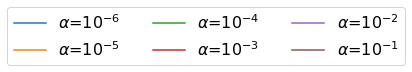

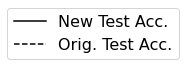

In [5]:
colors = ["C" + str(i) for i in range(len(lr_list))]
linestyles = ['-', "--"]

for tunealllayers in [True, False]:
    for i, arch in enumerate(arch_list):
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(1, 1, 1)
        for idx, lr in enumerate(lr_list):
            
            if arch == 'densenet' or arch == 'simplenet_mnist':
                tune = '_tunealllayers_'
            else:
                tune = '_tunalllayers_'
                
            name = name_dict_train[arch] + lr + tune + str(tunealllayers)
            
            history = load_obj(name)

            x_arr = np.arange(len(history['test_acc'])) + 1

            ax.plot(x_arr, history['test_acc'], c=colors[idx], ls=linestyles[0], label=r'New Test Acc. ($\alpha$=' + lr_map[lr] + ')')
            ax.plot(x_arr, history['test_acc_orig'], color=colors[idx], ls=linestyles[1], label=r'Orig. Test Acc. ($\alpha$=' + lr_map[lr] + ')')
            #ax.plot(x_arr, history['wm_acc'], c=colors[idx], ls=linestyles[2], label=r'WM Acc. ($\alpha$=' + lr_map[lr] + ')')


        ax.axhline(benchmarks_acc[arch], linestyle='-.', color='black', linewidth=1)
        # annotate axhline
        #ax.text(107,benchmarks_acc[arch], 'Test Acc. w/o WM')
        
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy')
        
        ax.set_ylim((0,101))
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        
        ax.yaxis.grid(True)
   
        plt.savefig('thesis/plots/finetuning_nonwm_model_thesis_' + arch + '_tunealllayers_'+ str(tunealllayers) +'.eps', bbox_inches="tight", facecolor='w', edgecolor='w')
        plt.close()
        
lines = ax.get_lines()
        
#dummy lines with NO entries, just to create the black style legend
dummy_lines = []
for j in range(len(linestyles)):
    dummy_lines.append(ax.plot([],[], c="black", ls = linestyles[j])[0])

# legend for linecolors
figsize = (4, 1)
fig_leg1 = plt.figure(figsize=figsize)
ax_leg1 = fig_leg1.add_subplot(111)
legend1 = plt.legend([lines[i] for i in np.arange(len(lr_list))*2], [r'$\alpha$='+lr_map[lr_list[i]] for i in range(len(lr_list))], ncol=3, bbox_to_anchor=(0.5, 0.5), loc='center')

ax_leg1.axis('off')
fig_leg1.savefig('thesis/plots/legend_finetuning_allvslast_colors.eps', bbox_inches='tight')

# legend for linestyles
figsize = (3, 1)
fig_leg2 = plt.figure(figsize=figsize)
ax_leg2 = fig_leg2.add_subplot(111)
legend2 = plt.legend(dummy_lines, ['New Test Acc.', 'Orig. Test Acc.', 'WM Acc.'], bbox_to_anchor=(0.5, 0.5), loc='center')

ax_leg2.axis('off')
fig_leg2.savefig('thesis/plots/legend_finetuning_allvslast_linetypes.eps', bbox_inches='tight')

### Small learning rates

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


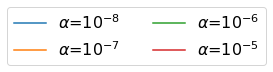

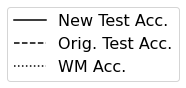

In [6]:
colors = ["C" + str(i) for i in range(len(small_lr_list))]
linestyles = ['-', "--", ":"]

for tunealllayers in [True]:
    for i, arch in enumerate(arch_list):
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(1, 1, 1)
        for idx, lr in enumerate(small_lr_list):
            
            name = name_dict_prot[arch] + 'transfer-learned_' + lr + '_tunealllayers_' + str(tunealllayers)
            
            history = load_obj(name)

            x_arr = np.arange(len(history['test_acc'])) + 1

            ax.plot(x_arr, history['test_acc'], c=colors[idx], ls=linestyles[0], label=r'New Test Acc. ($\alpha$=' + lr_map[lr] + ')')
            ax.plot(x_arr, history['test_acc_orig'], color=colors[idx], ls=linestyles[1], label=r'Orig. Test Acc. ($\alpha$=' + lr_map[lr] + ')')
            ax.plot(x_arr, history['wm_acc'], c=colors[idx], ls=linestyles[2], label=r'WM Acc. ($\alpha$=' + lr_map[lr] + ')')


        ax.axhline(benchmarks_acc[arch], linestyle='-.', color='black', linewidth=1)
        # annotate axhline
        #ax.text(107,benchmarks_acc[arch], 'Test Acc. w/o WM')
        
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy')
        
        ax.set_ylim((0,101))
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        
        ax.yaxis.grid(True)
        #ax.set_title('Fine-Tuning on ' + arch_lbl[arch] + ', ProtectingIP pattern')
        #ax.legend(ncol=len(lr_list), bbox_to_anchor=(0.5, -0.1), loc='upper center')    
        plt.savefig('thesis/plots/finetuning_protecting_content_smalllr_thesis_' + arch + '.eps', bbox_inches="tight", facecolor='w', edgecolor='w')
        plt.close()
        
lines = ax.get_lines()
        
#dummy lines with NO entries, just to create the black style legend
dummy_lines = []
for j in range(len(linestyles)):
    dummy_lines.append(ax.plot([],[], c="black", ls = linestyles[j])[0])

# legend for linecolors
figsize = (4, 1)
fig_leg1 = plt.figure(figsize=figsize)
ax_leg1 = fig_leg1.add_subplot(111)
legend1 = plt.legend([lines[i] for i in np.arange(len(small_lr_list))*3], [r'$\alpha$='+lr_map[small_lr_list[i]] for i in range(len(small_lr_list))], ncol=2, bbox_to_anchor=(0.5, 0.5), loc='center')

ax_leg1.axis('off')
fig_leg1.savefig('thesis/plots/legend_content_finetuning_smalllr_colors.eps', bbox_inches='tight')

# legend for linestyles
figsize = (3, 1)
fig_leg2 = plt.figure(figsize=figsize)
ax_leg2 = fig_leg2.add_subplot(111)
legend2 = plt.legend(dummy_lines, ['New Test Acc.', 'Orig. Test Acc.', 'WM Acc.'], bbox_to_anchor=(0.5, 0.5), loc='center')

ax_leg2.axis('off')
fig_leg2.savefig('thesis/plots/legend_content_finetuning_smalllr_linetypes.eps', bbox_inches='tight')

(0.0, 1.0, 0.0, 1.0)

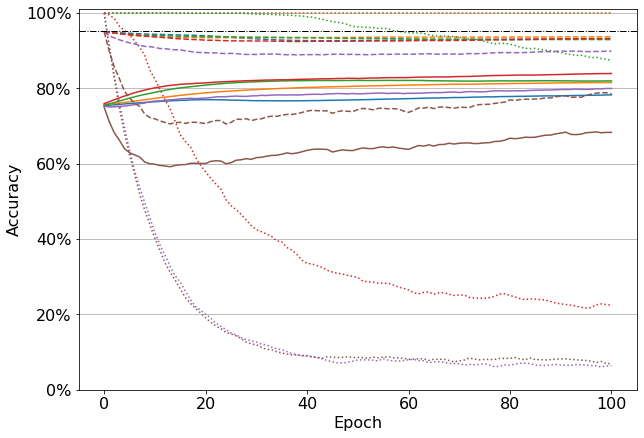

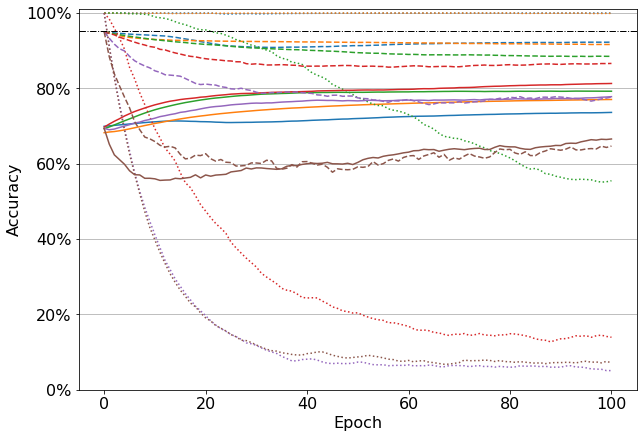

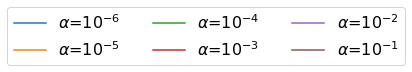

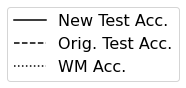

In [506]:
lrs = ['1e-06', '1e-05','0.0001', '0.001', '0.01','0.1']

colors = ["C" + str(i) for i in range(len(lrs))]
linestyles = ['-', "--", ":"]

names = [
        'transfer-learning_wm_protecting_content_resnet18_192_SGD_CosineAnnealingLR_100_',
        'transfer-learning_imagenet_wm_protecting_content_resnet18_192_SGD_CosineAnnealingLR_100_'
]
arch = 'resnet18'

for tunealllayers in [True]:
    for j, n in enumerate(names):
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(1, 1, 1)
        for idx, lr in enumerate(lrs):
            
            name = n + 'transfer-learned_' + lr + '_tunealllayers_' + str(tunealllayers)
            
            history = load_obj(name)

            x_arr = np.arange(len(history['test_acc']))

            ax.plot(x_arr, smooth(history['test_acc'],0.9), c=colors[idx], ls=linestyles[0], label=r'New Test Acc. ($\alpha$=' + lr_map[lr] + ')')
            ax.plot(x_arr, smooth(history['test_acc_orig'],0.9), color=colors[idx], ls=linestyles[1], label=r'Orig. Test Acc. ($\alpha$=' + lr_map[lr] + ')')
            ax.plot(x_arr, smooth(history['wm_acc'],0.9), c=colors[idx], ls=linestyles[2], label=r'WM Acc. ($\alpha$=' + lr_map[lr] + ')')


        ax.axhline(benchmarks_acc[arch], linestyle='-.', color='black', linewidth=1)
        # annotate axhline
        #ax.text(107,benchmarks_acc[arch], 'Test Acc. w/o WM')
        
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy')
        
        ax.set_ylim((0,101))
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        
        ax.yaxis.grid(True)
        #ax.set_title(name)
        #ax.set_title('Fine-Tuning on ' + arch_lbl[arch] + ', ProtectingIP pattern')
        #ax.legend(ncol=len(lr_list), bbox_to_anchor=(0.5, -0.1), loc='upper center')    
        plt.savefig('thesis/plots/finetuning_protecting_content_smoothed_imagenet_' + str(j) + '.eps', bbox_inches="tight", facecolor='w', edgecolor='w')
        #plt.close()
        
lines = ax.get_lines()
        
#dummy lines with NO entries, just to create the black style legend
dummy_lines = []
for j in range(len(linestyles)):
    dummy_lines.append(ax.plot([],[], c="black", ls = linestyles[j])[0])

# legend for linecolors
figsize = (4, 1)
fig_leg1 = plt.figure(figsize=figsize)
ax_leg1 = fig_leg1.add_subplot(111)
legend1 = plt.legend([lines[i] for i in np.arange(len(lrs))*3], [r'$\alpha$='+lr_map[lrs[i]] for i in range(len(lrs))], ncol=3, bbox_to_anchor=(0.5, 0.5), loc='center')

ax_leg1.axis('off')
#fig_leg1.savefig('thesis/plots/legend_content_finetuning_imagenet_colors.eps', bbox_inches='tight')

# legend for linestyles
figsize = (3, 1)
fig_leg2 = plt.figure(figsize=figsize)
ax_leg2 = fig_leg2.add_subplot(111)
legend2 = plt.legend(dummy_lines, ['New Test Acc.', 'Orig. Test Acc.', 'WM Acc.'], bbox_to_anchor=(0.5, 0.5), loc='center')

ax_leg2.axis('off')
#fig_leg2.savefig('thesis/plots/legend_content_finetuning_imagenet_linetypes.eps', bbox_inches='tight')

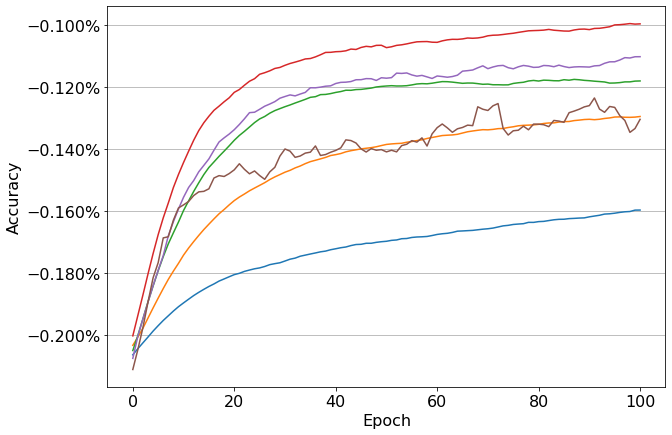

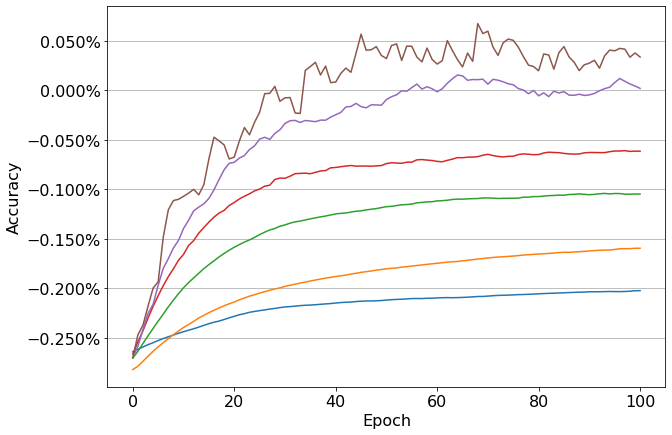

In [7]:
lrs = ['1e-06', '1e-05','0.0001', '0.001', '0.01','0.1']

colors = ["C" + str(i) for i in range(len(lrs))]
linestyles = ['-', "--", ":"]

names = ['transfer-learning_wm_protecting_content_resnet18_192_SGD_CosineAnnealingLR_100_',
         'transfer-learning_imagenet_wm_protecting_content_resnet18_192_SGD_CosineAnnealingLR_100_'
]
arch = 'resnet18'
a = 0.9  # smoothing factor

for tunealllayers in [True]:
    for j, n in enumerate(names):
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(1, 1, 1)
        for idx, lr in enumerate(lrs):
            
            name = n + 'transfer-learned_' + lr + '_tunealllayers_' + str(tunealllayers)
            
            history = load_obj(name)

            x_arr = np.arange(len(history['test_acc']))

            #ax.plot(x_arr, smooth(history['test_acc'],0.9), c=colors[idx], ls=linestyles[0], label=r'New Test Acc. ($\alpha$=' + lr_map[lr] + ')')
            #ax.plot(x_arr, smooth(history['test_acc_orig'],0.9), color=colors[idx], ls=linestyles[1], label=r'Orig. Test Acc. ($\alpha$=' + lr_map[lr] + ')')
            #ax.plot(x_arr, smooth(history['wm_acc'],0.9), c=colors[idx], ls=linestyles[2], label=r'WM Acc. ($\alpha$=' + lr_map[lr] + ')')
            
            rel_diff = []
            for epoch in range(len(history['test_acc'])):
                test_acc = history['test_acc'][epoch].item()
                test_acc_orig = history['test_acc_orig'][epoch].item()
                
                rel_diff.append((test_acc-test_acc_orig)/test_acc_orig)
                
            ax.plot(x_arr, smooth(rel_diff, a))
            #ax.plot(x_arr, rel_diff)
            
        #ax.axhline(benchmarks_acc[arch], linestyle='-.', color='black', linewidth=1)
        # annotate axhline
        #ax.text(107,benchmarks_acc[arch], 'Test Acc. w/o WM')
        
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy')
        
        #ax.set_ylim((0,101))
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        
        ax.yaxis.grid(True)
        #ax.set_title(name)
        #ax.set_title('Fine-Tuning on ' + arch_lbl[arch] + ', ProtectingIP pattern')
        #ax.legend(ncol=len(lr_list), bbox_to_anchor=(0.5, -0.1), loc='upper center')    
        plt.savefig('thesis/plots/finetuning_protecting_content_rel_diff_imagenet_' + str(j) + '.eps', bbox_inches="tight", facecolor='w', edgecolor='w')
        #plt.close()
        
lines = ax.get_lines()
        
#dummy lines with NO entries, just to create the black style legend
dummy_lines = []
for j in range(len(linestyles)):
    dummy_lines.append(ax.plot([],[], c="black", ls = linestyles[j])[0])

# legend for linecolors
figsize = (4, 1)
#fig_leg1 = plt.figure(figsize=figsize)
#ax_leg1 = fig_leg1.add_subplot(111)
#legend1 = plt.legend([lines[i] for i in np.arange(len(lrs))*3], [r'$\alpha$='+lr_map[lrs[i]] for i in range(len(lrs))], ncol=3, bbox_to_anchor=(0.5, 0.5), loc='center')

#ax_leg1.axis('off')
#fig_leg1.savefig('thesis/plots/legend_content_finetuning_imagenet_colors.eps', bbox_inches='tight')

# legend for linestyles
figsize = (3, 1)
#fig_leg2 = plt.figure(figsize=figsize)
#ax_leg2 = fig_leg2.add_subplot(111)
#legend2 = plt.legend(dummy_lines, ['New Test Acc.', 'Orig. Test Acc.', 'WM Acc.'], bbox_to_anchor=(0.5, 0.5), loc='center')

#ax_leg2.axis('off')
#fig_leg2.savefig('thesis/plots/legend_content_finetuning_imagenet_linetypes.eps', bbox_inches='tight')

### Large learning rates

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


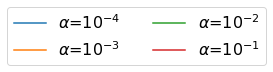

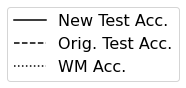

In [8]:
colors = ["C" + str(i) for i in range(len(large_lr_list))]
linestyles = ['-', "--", ":"]

for tunealllayers in [True]:
    for i, arch in enumerate(arch_list):
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(1, 1, 1)
        for idx, lr in enumerate(large_lr_list):
            
            name = name_dict_prot[arch] + 'transfer-learned_' + lr + '_tunealllayers_' + str(tunealllayers)
            
            history = load_obj(name)

            x_arr = np.arange(len(history['test_acc'])) + 1

            ax.plot(x_arr, history['test_acc'], c=colors[idx], ls=linestyles[0], label=r'New Test Acc. ($\alpha$=' + lr_map[lr] + ')')
            ax.plot(x_arr, history['test_acc_orig'], c=colors[idx], ls=linestyles[1], label=r'Orig. Test Acc. ($\alpha$=' + lr_map[lr] + ')')
            ax.plot(x_arr, history['wm_acc'], c=colors[idx], ls=linestyles[2], label=r'WM Acc. ($\alpha$=' + lr_map[lr] + ')')

        ax.axhline(benchmarks_acc[arch], linestyle='-.', color='black', linewidth=1)
        # annotate axhline
        #ax.text(107,benchmarks_acc[arch], 'Test Acc. w/o WM')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy')
        
        ax.set_ylim((0,101))
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        
        ax.yaxis.grid(True)
        #ax.set_title('Fine-Tuning on ' + arch_lbl[arch] + ', ProtectingIP pattern')
        #ax.legend(fontsize=10, ncol=len(lr_list), bbox_to_anchor=(0.5, -0.1), loc='upper center')    
        
        plt.savefig('thesis/plots/finetuning_protecting_content_largelr_thesis_' + arch + '.eps', bbox_inches="tight", facecolor='w', edgecolor='w')
        plt.close()
        
lines = ax.get_lines()
        
#dummy lines with NO entries, just to create the black style legend
dummy_lines = []
for j in range(len(linestyles)):
    dummy_lines.append(ax.plot([],[], c="black", ls = linestyles[j])[0])

# legend for linecolors
figsize = (4, 1)
fig_leg1 = plt.figure(figsize=figsize)
ax_leg1 = fig_leg1.add_subplot(111)
legend1 = plt.legend([lines[i] for i in np.arange(len(large_lr_list))*3], [r'$\alpha$='+lr_map[large_lr_list[i]] for i in range(len(large_lr_list))], ncol=2, bbox_to_anchor=(0.5, 0.5), loc='center')

ax_leg1.axis('off')
fig_leg1.savefig('thesis/plots/legend_content_finetuning_largelr_colors.eps', bbox_inches='tight')

# legend for linestyles
figsize = (3, 1)
fig_leg2 = plt.figure(figsize=figsize)
ax_leg2 = fig_leg2.add_subplot(111)
legend2 = plt.legend(dummy_lines, ['New Test Acc.', 'Orig. Test Acc.', 'WM Acc.'], bbox_to_anchor=(0.5, 0.5), loc='center')

ax_leg2.axis('off')
fig_leg2.savefig('thesis/plots/legend_content_finetuning_largelr_linetypes.eps', bbox_inches='tight')

## WeaknessIntoStrength embedding type pretrained vs. fromscratch

In [9]:
# Densenet, trg_set_size=100
pretrained = 'wm_weakness_pretrained_densenet_200_100_SGD_CosineAnnealingLR_100'
fromscratch = 'wm_weakness_fromscratch_densenet_200_100_SGD_CosineAnnealingLR_100'

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1,1,1)

ax_twin = ax.twinx()

colors = ["C0", "C1"]
linestyles = ['-', "--", ":"]

a = 0.99

# pretrained
history = load_obj(pretrained)

x_arr = np.arange(len(history['train_losses'])) + 1
        
lns1 = ax.plot(x_arr, smooth(history['train_losses'],a), c=colors[0], ls=linestyles[0], label='Train loss (pretrained)')
lns2 = ax.plot(x_arr, smooth(history['valid_losses'],a), c=colors[0], ls=linestyles[1], label='Valid. loss (pretrained)')
lns3 = ax_twin.plot(x_arr, smooth(history['wm_acc'],a), c=colors[0], ls=linestyles[2], label='WM Acc. (pretrained)')

# fromscratch
history = load_obj(fromscratch)

x_arr = np.arange(len(history['train_losses'])) + 1
        
lns4 = ax.plot(x_arr, smooth(history['train_losses'],a), c=colors[1], ls=linestyles[0], label='Train loss (fromscratch)')
lns5 = ax.plot(x_arr, smooth(history['valid_losses'],a), c=colors[1], ls=linestyles[1], label='Valid. loss (fromscratch)')
lns6 = ax_twin.plot(x_arr, smooth(history['wm_acc'],a), c=colors[1], ls=linestyles[2], label='WM Acc. (fromscratch)')

#added these six lines
lns = lns1+lns2+lns3+lns4+lns5+lns6
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, ncol=2, bbox_to_anchor=(0.5, -0.11), loc='upper center')

ax_twin.yaxis.set_major_formatter(mtick.PercentFormatter())

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax_twin.set_ylabel('Accuracy')

#ax.set_title('WeaknessIntoStrength: embedding type pretrained vs. fromscratch', fontsize=16)

ax_twin.yaxis.grid(True)

#plt.show()
plt.savefig('thesis/plots/weakness_pretrained_vs_fromscratch_smoothed_' + str(a) + '.eps', bbox_inches='tight')
plt.close()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


## FrontierStitching: fidelity

densenet
[tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.)]
resnet18
[tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.)]
resnet34
[tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.)]
resnet50
[tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.)]
simplenet_mnist
[tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.)]
lenet1
[tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.)]
lenet3
[tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.)]
lenet5
[tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(68.), tensor(100.), tensor(100.)]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


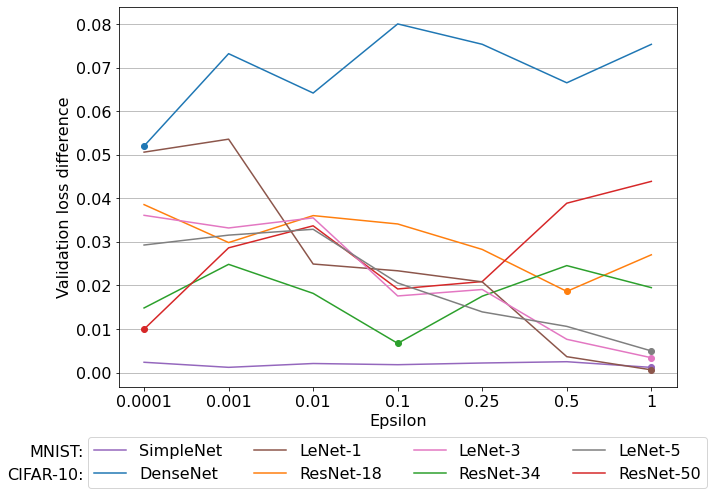

In [10]:
name_front = {'densenet': 'wm_frontier_densenet_SGD_CosineAnnealingLR_augmented_200_size100_epsilon',
            'lenet1': 'wm_frontier_lenet1_ADAM_MultiStepLR_augmented_100_size100_epsilon',
            'lenet3': 'wm_frontier_lenet3_SGD_MultiStepLR_augmented_100_size100_epsilon',
            'lenet5': 'wm_frontier_lenet5_SGD_MultiStepLR_augmented_100_size100_epsilon',
            'resnet18': 'wm_frontier_resnet18_SGD_CosineAnnealingLR_augmented_200_size100_epsilon',
            'resnet34': 'wm_frontier_resnet34_SGD_CosineAnnealingLR_augmented_200_size100_epsilon',
            'resnet50': 'wm_frontier_resnet50_SGD_CosineAnnealingLR_augmented_200_size100_epsilon',
            'simplenet_mnist': 'wm_frontier_simplenet_mnist_SGD_MultiStepLR_augmented_50_size100_epsilon'}

name_back = {'densenet': '_SGD_CosineAnnealingLR_100',
            'lenet1': '_ADAM_MultiStepLR_100',
            'lenet3': '_SGD_MultiStepLR_100',
            'lenet5': '_SGD_MultiStepLR_100',
            'resnet18': '_SGD_CosineAnnealingLR_100',
            'resnet34': '_SGD_CosineAnnealingLR_100',
            'resnet50': '_SGD_CosineAnnealingLR_100',
            'simplenet_mnist': '_SGD_MultiStepLR_100'}


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1)

best_acc_dict = {}
for i, arch in enumerate(arch_list):
    eps = ['0.0001', '0.001', '0.01', '0.1', '0.25', '0.5', '1']
    
    best_valids = []
    best_acc = []
    best_wm = []
    valid_err = []

    for e in eps:
        name = name_front[arch] + e + name_back[arch]
        history = load_obj(name)
    
        best_epoch = np.argmin(history["valid_losses"])
        min_valid = history["valid_losses"][best_epoch]
        acc = history["test_acc"][best_epoch]
        wm = history["wm_acc"][best_epoch]
    
        err = min_valid - benchmarks_valid[arch]
        valid_err.append(err)
        best_valids.append(min_valid)
        best_acc.append(acc)
        best_wm.append(wm) 
    
    best_acc_dict[arch] = best_acc
    
    argmin = np.argmin(valid_err)
    
    ax.plot(eps, valid_err, 'C' + str(i), label=arch_lbl[arch])
    ax.plot(eps[argmin], valid_err[argmin], 'C' + str(i) + 'o')
    ax.set_xlabel('Epsilon')
    ax.set_ylabel('Validation loss difference') #  (compared to model w/o WM)
    ax.yaxis.grid(True)
    

handles, labels = ax.get_legend_handles_labels()

handles = [handles[i] for i in [4,0,5,1,6,2,7,3]]
labels = [labels[i] for i in [4,0,5,1,6,2,7,3]]

ax.annotate('CIFAR-10:', xy=(-35, -80), xycoords='axes points',
            size=16, ha='right', va='top')

ax.annotate('MNIST:', xy=(-35, -57), xycoords='axes points',
            size=16, ha='right', va='top')

ax.legend(handles, labels, ncol=4, bbox_to_anchor=(0.5, -0.11), loc='upper center')
plt.savefig('thesis/plots/frontier_influence_epsilon_validloss.eps', bbox_inches="tight")

## FrontierStitching: relative validation loss diff

densenet
[tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.)]
resnet18
[tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.)]
resnet34
[tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.)]
resnet50
[tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.)]
simplenet_mnist
[tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.)]
lenet1
[tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.)]
lenet3
[tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.)]
lenet5
[tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(68.), tensor(100.), tensor(100.)]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


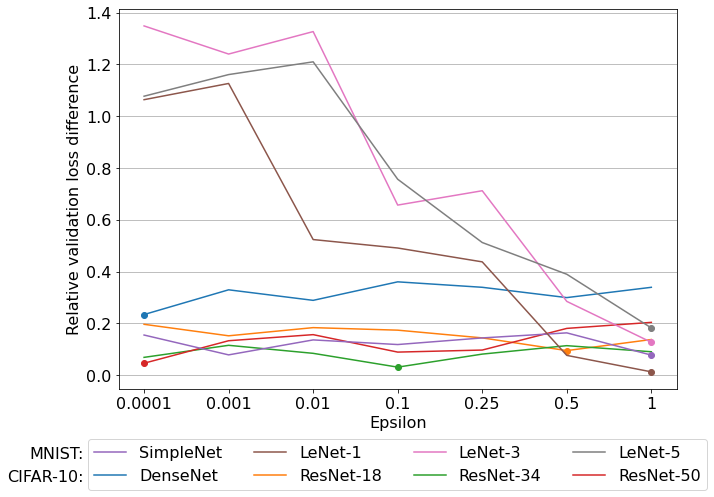

In [12]:
name_front = {'densenet': 'wm_frontier_densenet_SGD_CosineAnnealingLR_augmented_200_size100_epsilon',
            'lenet1': 'wm_frontier_lenet1_ADAM_MultiStepLR_augmented_100_size100_epsilon',
            'lenet3': 'wm_frontier_lenet3_SGD_MultiStepLR_augmented_100_size100_epsilon',
            'lenet5': 'wm_frontier_lenet5_SGD_MultiStepLR_augmented_100_size100_epsilon',
            'resnet18': 'wm_frontier_resnet18_SGD_CosineAnnealingLR_augmented_200_size100_epsilon',
            'resnet34': 'wm_frontier_resnet34_SGD_CosineAnnealingLR_augmented_200_size100_epsilon',
            'resnet50': 'wm_frontier_resnet50_SGD_CosineAnnealingLR_augmented_200_size100_epsilon',
            'simplenet_mnist': 'wm_frontier_simplenet_mnist_SGD_MultiStepLR_augmented_50_size100_epsilon'}

name_back = {'densenet': '_SGD_CosineAnnealingLR_100',
            'lenet1': '_ADAM_MultiStepLR_100',
            'lenet3': '_SGD_MultiStepLR_100',
            'lenet5': '_SGD_MultiStepLR_100',
            'resnet18': '_SGD_CosineAnnealingLR_100',
            'resnet34': '_SGD_CosineAnnealingLR_100',
            'resnet50': '_SGD_CosineAnnealingLR_100',
            'simplenet_mnist': '_SGD_MultiStepLR_100'}


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1)

# open file
f = open('plots_thesis_tables/frontier_fidelity_plots_thesis.csv', 'w')

# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
row = ['Arch', 'eps', 'Rel. valid. loss diff.']
writer.writerow(row)


best_acc_dict = {}
for i, arch in enumerate(arch_list):
    eps = ['0.0001', '0.001', '0.01', '0.1', '0.25', '0.5', '1']
    
    best_valids = []
    best_acc = []
    best_wm = []
    valid_err = []

    for e in eps:
        name = name_front[arch] + e + name_back[arch]
        history = load_obj(name)
    
        best_epoch = np.argmin(history["valid_losses"])
        min_valid = history["valid_losses"][best_epoch]
        acc = history["test_acc"][best_epoch]
        wm = history["wm_acc"][best_epoch]
    
        err = (min_valid - benchmarks_valid[arch])/benchmarks_valid[arch]
        valid_err.append(err)
        best_valids.append(min_valid)
        best_acc.append(acc)
        best_wm.append(wm)
        
        row = [arch_lbl[arch], e, round(err,4)]
        writer.writerow(row)
    
    best_acc_dict[arch] = best_acc
    
    argmin = np.argmin(valid_err)
    
    ax.plot(eps, valid_err, 'C' + str(i), label=arch_lbl[arch])
    ax.plot(eps[argmin], valid_err[argmin], 'C' + str(i) + 'o')
    ax.set_xlabel('Epsilon')
    ax.set_ylabel('Relative validation loss difference') #  (compared to model w/o WM)
    ax.yaxis.grid(True)


handles, labels = ax.get_legend_handles_labels()

handles = [handles[i] for i in [4,0,5,1,6,2,7,3]]
labels = [labels[i] for i in [4,0,5,1,6,2,7,3]]

ax.annotate('CIFAR-10:', xy=(-35, -80), xycoords='axes points',
            size=16, ha='right', va='top')

ax.annotate('MNIST:', xy=(-35, -57), xycoords='axes points',
            size=16, ha='right', va='top')

ax.legend(handles, labels, ncol=4, bbox_to_anchor=(0.5, -0.11), loc='upper center')
#ax.set_title('FrontierStitching: Influence of epsilon on validation loss')
plt.savefig('thesis/plots/frontier_influence_epsilon_validloss_relative.eps', bbox_inches="tight")

# close the file
f.close()

## FrontierStitching: pruning

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


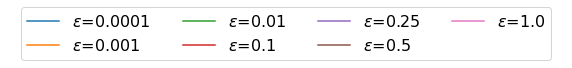

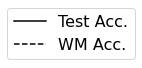

In [13]:
df = pd.read_csv('save_results/pruning/save_results_pruning_frontier_varyeps.csv', sep=';')

# open file
f = open('plots_thesis_tables/frontier_pruning_plots_thesis.csv', 'w')

# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
row = ['Arch', 'eps', '0.1', '0.1', '0.2', '0.2', '0.3','0.3', '0.4','0.4', '0.5','0.5', '0.6','0.6', '0.7','0.7', '0.8','0.8', '0.9','0.9']
writer.writerow(row)
        
for i, arch in enumerate(arch_list):
    
    df_arch = df[df['arch'] == arch]
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(1, 1, 1)
    
    colors = ["C" + str(i) for i in range(len(pd.unique(df_arch['eps'])))]
    linestyles = ['-', "--"]

    for i, eps in enumerate(pd.unique(df_arch['eps'])):
        df_eps = df_arch[df_arch['eps'] == eps]
        ax.plot(df_eps['pruning_rate'], df_eps['test_acc'], c= colors[i], ls=linestyles[0], label = r'Test Acc. ($\epsilon$=' + str(eps) + ')')
        ax.plot(df_eps['pruning_rate'], df_eps['wm_acc'], c= colors[i], ls=linestyles[1], label = r'WM Acc. ($\epsilon$=' + str(eps) + ')')

        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax.set_xlabel('Pruning rate')
        ax.set_ylabel('Accuracy')
        ax.yaxis.grid(True)
    
        #print(df_eps['wm_acc'])
        
        row = [arch_lbl[arch], eps]
        for j, pr in enumerate(pd.unique(df_eps['pruning_rate'])):
            k = df_eps.index[df_eps['pruning_rate'] == pr]
            try:
                test_acc = df_eps['test_acc'][k].item()
                wm_acc = df_eps['wm_acc'][k].item()
            except:
                test_acc = None
                wm_acc = None
                
            row = row + [round(test_acc,2), round(wm_acc,2)]
        
        writer.writerow(row)
    
    ax.set_ylim(80, 101)
    #ax.legend()
    
    ax.axhline(benchmarks_acc[arch]-3.5, linestyle='dotted', color='black', linewidth=2)
    #ax.text(0.95, benchmarks_acc[arch]-3.5, 'Threshold')
    
    plt.savefig('thesis/plots/frontier_influence_epsilon_pruning_' + arch + '.eps', bbox_inches="tight", facecolor='w')
    plt.close()

lines = ax.get_lines()
# legend for colors        
figsize = (10, 1)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)

legend = plt.legend([lines[i] for i in np.arange(len(pd.unique(df_arch['eps'])))*2], [r'$\epsilon$=' + str(pd.unique(df_arch['eps'])[i].item()) for i in range(len(pd.unique(df_arch['eps'])))], ncol=4, bbox_to_anchor=(0.5, 0.5), loc='center')

ax_leg.axis('off')
fig_leg.savefig('thesis/plots/legend_frontier_pruning_perarch_colors.eps', bbox_inches='tight')
plt.close()


# legend for linestyles
#dummy lines with NO entries, just to create the black style legend
dummy_lines = []
for j in range(len(linestyles)):
    dummy_lines.append(ax.plot([],[], c="black", ls = linestyles[j])[0])
    
figsize = (2, 1)
fig_leg1 = plt.figure(figsize=figsize)
ax_leg1 = fig_leg1.add_subplot(111)
legend1 = plt.legend(dummy_lines, ['Test Acc.', 'WM Acc.'], bbox_to_anchor=(0.5, 0.5), loc='center') # , 'Orig. Test Acc.'
ax_leg1.axis('off')
fig_leg1.savefig('thesis/plots/legend_frontier_pruning_perarch_linetypes.eps', bbox_inches='tight')
plt.close()

for arch in arch_list:
    df_arch = df[df['arch'] == arch]
    for idx, eps in enumerate([0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 1.0]):
        df_eps = df_arch[df_arch['eps'] == eps]

        bench = best_acc_dict[arch][idx].item()
        df_keep = df_eps[df_eps['test_acc'] >= bench - 3.5]
        df_keep = df_keep[df_keep['pruning_rate'] == np.max(df_keep['pruning_rate'])]
        
f.close()

# Evaluation

In [14]:
my_xticks_arch = {
    'densenet': [20, 100, 500],
        'resnet18': [20, 100, 500],
        'resnet34': [20, 100, 500],
        'resnet50': [20, 100, 500],
        'simplenet_mnist': [24, 120, 600], 
        'lenet1': [24, 120, 600], 
        'lenet3': [24, 120, 600], 
        'lenet5': [24, 120, 600]
}

my_xticks_method = {
    'ProtectingIP-pattern': [20, 100, 500, 600],
    'ProtectingIP-noise': [20, 100, 500, 600],
    'ProtectingIP-OOD': [20, 100, 500, 600],
    'WeaknessIntoStrength': [20, 100], 
    'PiracyResistant': [20, 100, 500, 600],
    'ExponentialWeighting': [20, 100, 500, 600],
    'FrontierStitching': [20, 100, 500, 600],
    'WMEmbeddedSystems': [20, 100, 500, 600],
    'Blackmarks': [20, 100, 500, 600]
}

methods = ['ProtectingIP-pattern', 'ProtectingIP-noise', 'ProtectingIP-OOD', 'WeaknessIntoStrength', 
           'PiracyResistant','ExponentialWeighting', 'FrontierStitching', 'WMEmbeddedSystems'
          ]

colors = ["C" + str(i) for i in range(len(methods))]

name_front_all = {
    'WeaknessIntoStrength': {
        'densenet': 'wm_weakness_fromscratch_densenet_200_100_SGD_CosineAnnealingLR_',
        'resnet18': 'wm_weakness_fromscratch_resnet18_192_100_SGD_CosineAnnealingLR_',
        'resnet34': 'wm_weakness_fromscratch_resnet34_195_100_SGD_CosineAnnealingLR_',
        'resnet50': 'wm_weakness_fromscratch_resnet50_195_100_SGD_CosineAnnealingLR_',
        'simplenet_mnist': 'wm_weakness_fromscratch_simplenet_mnist_24_100_SGD_MultiStepLR_',
        'lenet1': 'wm_weakness_fromscratch_lenet1_48_100_ADAM_MultiStepLR_',
        'lenet3': 'wm_weakness_fromscratch_lenet3_55_100_SGD_MultiStepLR_',
        'lenet5': 'wm_weakness_fromscratch_lenet5_42_100_SGD_MultiStepLR_'
             },
    'ProtectingIP-OOD': {
        'densenet': 'wm_protecting_unrelated_densenet_200_SGD_CosineAnnealingLR_',
        'resnet18': 'wm_protecting_unrelated_resnet18_192_SGD_CosineAnnealingLR_',
        'resnet34': 'wm_protecting_unrelated_resnet34_195_SGD_CosineAnnealingLR_',
        'resnet50': 'wm_protecting_unrelated_resnet50_192_SGD_CosineAnnealingLR_',
        'simplenet_mnist': 'wm_protecting_unrelated_simplenet_mnist_24_SGD_MultiStepLR_',
        'lenet1': 'wm_protecting_unrelated_lenet1_48_ADAM_MultiStepLR_',
        'lenet3': 'wm_protecting_unrelated_lenet3_55_SGD_MultiStepLR_',
        'lenet5': 'wm_protecting_unrelated_lenet5_42_SGD_MultiStepLR_'
             },
    'ProtectingIP-noise': {
        'densenet': 'wm_protecting_noise_densenet_200_SGD_CosineAnnealingLR_',
        'resnet18': 'wm_protecting_noise_resnet18_192_SGD_CosineAnnealingLR_',
        'resnet34': 'wm_protecting_noise_resnet34_195_SGD_CosineAnnealingLR_',
        'resnet50': 'wm_protecting_noise_resnet50_192_SGD_CosineAnnealingLR_',
        'simplenet_mnist': 'wm_protecting_noise_simplenet_mnist_24_SGD_MultiStepLR_',
        'lenet1': 'wm_protecting_noise_lenet1_48_ADAM_MultiStepLR_',
        'lenet3': 'wm_protecting_noise_lenet3_55_SGD_MultiStepLR_',
        'lenet5': 'wm_protecting_noise_lenet5_42_SGD_MultiStepLR_'
             },
    'ProtectingIP-pattern': {
        'densenet': 'wm_protecting_content_densenet_200_SGD_CosineAnnealingLR_',
        'resnet18': 'wm_protecting_content_resnet18_192_SGD_CosineAnnealingLR_',
        'resnet34': 'wm_protecting_content_resnet34_195_SGD_CosineAnnealingLR_',
        'resnet50': 'wm_protecting_content_resnet50_192_SGD_CosineAnnealingLR_',
        'simplenet_mnist': 'wm_protecting_content_simplenet_mnist_24_SGD_MultiStepLR_',
        'lenet1': 'wm_protecting_content_lenet1_48_ADAM_MultiStepLR_',
        'lenet3': 'wm_protecting_content_lenet3_55_SGD_MultiStepLR_',
        'lenet5': 'wm_protecting_content_lenet5_42_SGD_MultiStepLR_'
             },
    
    'PiracyResistant': {
        'densenet': 'wm_piracy_densenet_200fixlmbdafixpatternsize_SGD_CosineAnnealingLR_',
        'resnet18': 'wm_piracy_resnet18_200fixlmbdafixpatternsize_SGD_CosineAnnealingLR_',
        'resnet34': 'wm_piracy_resnet34_200fixlmbdafixpatternsize_SGD_CosineAnnealingLR_',
        'resnet50': 'wm_piracy_resnet50_200fixlmbdafixpatternsize_SGD_CosineAnnealingLR_',
        'simplenet_mnist': 'wm_piracy_simplenet_mnist_50fixlmbdafixpatternsize_SGD_MultiStepLR_',
        'lenet1': 'wm_piracy_lenet1_100fixlmbdafixpatternsize_ADAM_MultiStepLR_',
        'lenet3': 'wm_piracy_lenet3_100fixlmbdafixpatternsize_SGD_MultiStepLR_',
        'lenet5': 'wm_piracy_lenet5_100fixlmbdafixpatternsize_SGD_MultiStepLR_'
             },
    'ExponentialWeighting': {
        'densenet': 'wm_exponential_exponentialnew_densenet_200_SGD_CosineAnnealingLR_',
        'resnet18': 'wm_exponential_exponential_new_resnet18_200_SGD_CosineAnnealingLR_',
        'resnet34': 'wm_exponential_exponential_new_resnet34_200_SGD_CosineAnnealingLR_',
        'resnet50': 'wm_exponential_exponential_new_resnet50_200_SGD_CosineAnnealingLR_',
        'simplenet_mnist': 'wm_exponential_exponentialnew_simplenet_mnist_50_SGD_MultiStepLR_',
        'lenet1': 'wm_exponential_exponentialnew_lenet1_50_ADAM_MultiStepLR_',
        'lenet3': 'wm_exponential_exponentialnew_lenet3_50_SGD_MultiStepLR_',
        'lenet5': 'wm_exponential_exponentialnew_lenet5_50_SGD_MultiStepLR_'
             },
    'FrontierStitching': {
        'densenet': 'wm_frontier_densenet_SGD_CosineAnnealingLR_augmented_200_size100_epsilon0.25_SGD_CosineAnnealingLR_',
        'resnet18': 'wm_frontier_resnet18_SGD_CosineAnnealingLR_augmented_200_size100_epsilon0.25_SGD_CosineAnnealingLR_',
        'resnet34': 'wm_frontier_resnet34_SGD_CosineAnnealingLR_augmented_200_size100_epsilon0.25_SGD_CosineAnnealingLR_',
        'resnet50': 'wm_frontier_resnet50_SGD_CosineAnnealingLR_augmented_200_size100_epsilon0.25_SGD_CosineAnnealingLR_',
        'simplenet_mnist': 'wm_frontier_simplenet_mnist_SGD_MultiStepLR_augmented_50_size100_epsilon0.25_SGD_MultiStepLR_',
        'lenet1': 'wm_frontier_lenet1_ADAM_MultiStepLR_augmented_100_size100_epsilon0.25_ADAM_MultiStepLR_',
        'lenet3': 'wm_frontier_lenet3_SGD_MultiStepLR_augmented_100_size100_epsilon0.25_SGD_MultiStepLR_',
        'lenet5': 'wm_frontier_lenet5_SGD_MultiStepLR_augmented_100_size100_epsilon0.25_SGD_MultiStepLR_'
             },
    'WMEmbeddedSystems': {
        'densenet': 'wm_embedded_densenet_200_eps0.1_SGD_CosineAnnealingLR_',
        'resnet18': 'wm_embedded_resnet18_200_eps0.1_SGD_CosineAnnealingLR_',
        'resnet34': 'wm_embedded_resnet34_200_eps0.1_SGD_CosineAnnealingLR_',
        'resnet50': 'wm_embedded_resnet50_200_eps0.1_SGD_CosineAnnealingLR_',
        'simplenet_mnist': 'wm_embedded_simplenet_mnist_50_eps1.0_SGD_MultiStepLR_',
        'lenet1': 'wm_embedded_lenet1_100_eps1.0_SGD_MultiStepLR_',
        'lenet3': 'wm_embedded_lenet3_100_eps1.0_SGD_MultiStepLR_',
        'lenet5': 'wm_embedded_lenet5_100_eps1.0_SGD_MultiStepLR_'
             }
            }

# Evaluation: fidelity per arch

Absolute difference

In [16]:
for i, arch in enumerate(arch_list):
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(1, 1, 1)
    ax.xaxis.set_ticks(my_xticks_arch[arch])
    
    for j, method in enumerate(methods):
        
        if method == 'WeaknessIntoStrength':
            trg_set_sizes = {
                'densenet': [20, 100],
                'resnet18': [20, 100],
                'resnet34': [20, 100],
                'resnet50': [20, 100],
                'simplenet_mnist': [20, 100],
                'lenet1': [20, 100],
                'lenet3': [20, 100],
                'lenet5': [20, 100]
            }
        else:
            trg_set_sizes = {
                'densenet': [20, 100, 500],
                'resnet18': [20, 100, 500],
                'resnet34': [20, 100, 500],
                'resnet50': [20, 100, 500],
                'simplenet_mnist': [24, 120, 600], # mit 12
                'lenet1': [24, 120, 600],
                'lenet3': [24, 120, 600],
                'lenet5': [24, 120, 600]
            }
        
        if method == 'Blackmarks' and arch == 'resnet50':
            continue
        
        test_acc_list = []
        test_acc_diff = []
        wm_acc = []

        for trg_set_size in trg_set_sizes[arch]:
            
            name = name_front_all[method][arch] + str(trg_set_size)

            history = load_obj(name)
            
            argmin = np.argmin(history['valid_losses'])
            test_acc_list.append(history['test_acc'][argmin])
            test_acc_diff.append(history['test_acc'][argmin]-benchmarks_acc[arch])
            wm_acc.append(history['wm_acc'][argmin])
        
        #if method == 'ExponentialWeighting':
        #    print("%s, %s " % (arch, method))
        #    print(wm_acc)
        #    print("\n")
        
        sizes_str =['{}'.format(i) for i in trg_set_sizes[arch]]
        ax.plot(trg_set_sizes[arch], test_acc_diff, '-o', c=colors[j], label=method)
        
    ax.set_xlabel('Trigger set size')
    ax.set_ylabel('Test accuracy difference (in percentage points)')
    
    ax.xaxis.set_ticks(my_xticks_arch[arch])
    
    ax.yaxis.grid(True)
    ax.set_ylim((-3.5,0.5))

    plt.savefig('thesis/plots/' + arch + '_fidelity_per_arch.eps', bbox_inches='tight')
    plt.close()

figsize = (13, 1)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
ax_leg.legend(*ax.get_legend_handles_labels(),ncol=4, bbox_to_anchor=(0.5, 0.5), loc='center')
ax_leg.axis('off')
fig_leg.savefig('thesis/plots/legend_fidelity_per_arch.eps', bbox_inches='tight')
plt.close()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Relative difference

In [17]:
for i, arch in enumerate(arch_list):
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(1, 1, 1)
    ax.xaxis.set_ticks(my_xticks_arch[arch])
    
    for j, method in enumerate(methods):
        
        if method == 'WeaknessIntoStrength':
            trg_set_sizes = {
                'densenet': [20, 100],
                'resnet18': [20, 100],
                'resnet34': [20, 100],
                'resnet50': [20, 100],
                'simplenet_mnist': [20, 100],
                'lenet1': [20, 100],
                'lenet3': [20, 100],
                'lenet5': [20, 100]
            }
        else:
            trg_set_sizes = {
                'densenet': [20, 100, 500],
                'resnet18': [20, 100, 500],
                'resnet34': [20, 100, 500],
                'resnet50': [20, 100, 500],
                'simplenet_mnist': [24, 120, 600], # mit 12
                'lenet1': [24, 120, 600],
                'lenet3': [24, 120, 600],
                'lenet5': [24, 120, 600]
            }
        
        if method == 'Blackmarks' and arch == 'resnet50':
            continue
        
        test_acc_list = []
        test_acc_diff = []
        wm_acc = []

        for trg_set_size in trg_set_sizes[arch]:
            
            name = name_front_all[method][arch] + str(trg_set_size)

            history = load_obj(name)
            
            argmin = np.argmin(history['valid_losses'])
            test_acc_list.append(history['test_acc'][argmin])
            test_acc_diff.append((history['test_acc'][argmin]-benchmarks_acc[arch])/benchmarks_acc[arch])
            wm_acc.append(history['wm_acc'][argmin])
        
        ax.plot(trg_set_sizes[arch], test_acc_diff, '-o', c=colors[j], label=method)
        
    ax.set_xlabel('Trigger set size')
    ax.set_ylabel('Realtive test accuracy difference')
    
    ax.xaxis.set_ticks(my_xticks_arch[arch])
    
    ax.yaxis.grid(True)
    ax.set_ylim((-0.05,0.01))

    plt.savefig('thesis/plots/' + arch + '_fidelity_rel_per_arch.eps', bbox_inches='tight')
    plt.close()

figsize = (13, 1)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
ax_leg.legend(*ax.get_legend_handles_labels(),ncol=4, bbox_to_anchor=(0.5, 0.5), loc='center')
ax_leg.axis('off')
fig_leg.savefig('thesis/plots/legend_fidelity_rel_per_arch.eps', bbox_inches='tight')
plt.close()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


# Evaluation: fidelity per method

Absolute difference

In [18]:
for i, method in enumerate(methods):
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(1, 1, 1)
    ax.xaxis.set_ticks(my_xticks_method[method])
    
    for j, arch in enumerate(arch_list):
        
        if method == 'WeaknessIntoStrength':
            trg_set_sizes = {
                'densenet': [20, 100],
                'resnet18': [20, 100],
                'resnet34': [20, 100],
                'resnet50': [20, 100],
                'simplenet_mnist': [20, 100],
                'lenet1': [20, 100],
                'lenet3': [20, 100],
                'lenet5': [20, 100]
            }
        else:
            trg_set_sizes = {
                'densenet': [20, 100, 500],
                'resnet18': [20, 100, 500],
                'resnet34': [20, 100, 500],
                'resnet50': [20, 100, 500],
                'simplenet_mnist': [12, 24, 120, 600],
                'lenet1': [24, 120, 600],
                'lenet3': [24, 120, 600],
                'lenet5': [24, 120, 600]
            }
        
        if method == 'Blackmarks' and arch == 'resnet50':
            continue
        
        test_acc_list = []
        test_acc_diff = []
        wm_acc = []

        for trg_set_size in trg_set_sizes[arch]:
            
            name = name_front_all[method][arch] + str(trg_set_size)

            history = load_obj(name)
            
            argmin = np.argmin(history['valid_losses'])
            test_acc_list.append(history['test_acc'][argmin])
            test_acc_diff.append(history['test_acc'][argmin]-benchmarks_acc[arch])
            wm_acc.append(history['wm_acc'][argmin])
        
        sizes_str =['{}'.format(i) for i in trg_set_sizes[arch]]
        ax.plot(trg_set_sizes[arch], test_acc_diff, '-o', c=colors[j], label=arch_lbl[arch])
        
    ax.set_xlabel('Trigger set size')
    ax.set_ylabel('Test accuracy difference (in percentage points)')
    
    ax.xaxis.set_ticks(my_xticks_method[method])
    
    ax.yaxis.grid(True)
    ax.set_ylim((-3.5,0.5))

    if method == 'WeaknessIntoStrength':
        handles, labels = ax.get_legend_handles_labels()
        
    plt.savefig('thesis/plots/' + method + '_fidelity_per_method.eps', bbox_inches='tight')
    plt.close()


figsize = (13, 1)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)

handles = [handles[i] for i in [4,0,5,1,6,2,7,3]]
labels = [labels[i] for i in [4,0,5,1,6,2,7,3]]

ax_leg.legend(handles, labels, ncol=4, bbox_to_anchor=(0.5, 0.5), loc='center')

ax_leg.annotate('CIFAR-10:', xy=(40, 24), xycoords='axes points', size=16, ha='right', va='top')
ax_leg.annotate('MNIST:', xy=(40, 47), xycoords='axes points', size=16, ha='right', va='top')

ax_leg.axis('off')
fig_leg.savefig('thesis/plots/legend_fidelity_per_method.eps', bbox_inches='tight')
plt.close()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Relative difference

In [19]:
# open file
f = open('plots_thesis_tables/evaluation_fidelity_rel_per_method.csv', 'w')

# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
row = ['Method', 'size'] + [arch_lbl[arch] for arch in arch_list]
writer.writerow(row)

for i, method in enumerate(methods):
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(1, 1, 1)
    ax.xaxis.set_ticks(my_xticks_method[method])
    
    #csv_args = {}
    for j, arch in enumerate(arch_list):
        
        #csv_args[arch] = {}
        if method == 'WeaknessIntoStrength':
            trg_set_sizes = {
                'densenet': [20, 100],
                'resnet18': [20, 100],
                'resnet34': [20, 100],
                'resnet50': [20, 100],
                'simplenet_mnist': [20, 100],
                'lenet1': [20, 100],
                'lenet3': [20, 100],
                'lenet5': [20, 100]
            }
        else:
            trg_set_sizes = {
                'densenet': [20, 100, 500],
                'resnet18': [20, 100, 500],
                'resnet34': [20, 100, 500],
                'resnet50': [20, 100, 500],
                'simplenet_mnist': [12, 24, 120, 600],
                'lenet1': [24, 120, 600],
                'lenet3': [24, 120, 600],
                'lenet5': [24, 120, 600]
            }
        
        test_acc_list = []
        test_acc_diff = []
        wm_acc = []

        for trg_set_size in trg_set_sizes[arch]:
            
            name = name_front_all[method][arch] + str(trg_set_size)

            history = load_obj(name)
            
            argmin = np.argmin(history['valid_losses'])
            test_acc_list.append(history['test_acc'][argmin])
            test_acc_diff.append((history['test_acc'][argmin]-benchmarks_acc[arch])/benchmarks_acc[arch])
            wm_acc.append(history['wm_acc'][argmin])
        
        
        sizes_str =['{}'.format(i) for i in trg_set_sizes[arch]]
        ax.plot(trg_set_sizes[arch], test_acc_diff, '-o', c=colors[j], label=arch_lbl[arch])
        
    ax.set_xlabel('Trigger set size')
    ax.set_ylabel('Relative test accuracy difference')
    
    ax.xaxis.set_ticks(my_xticks_method[method])
    
    ax.yaxis.grid(True)
    ax.set_ylim((-0.05,0.005))
    

    if method == 'WeaknessIntoStrength':
        handles, labels = ax.get_legend_handles_labels()
        
    plt.savefig('thesis/plots/' + method + '_fidelity_rel_per_method.eps', bbox_inches='tight')
    plt.close()


figsize = (13, 1)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)

#handles, labels = ax.get_legend_handles_labels()
handles = [handles[i] for i in [4,0,5,1,6,2,7,3]]
labels = [labels[i] for i in [4,0,5,1,6,2,7,3]]

ax_leg.legend(handles, labels, ncol=4, bbox_to_anchor=(0.5, 0.5), loc='center')

ax_leg.annotate('CIFAR-10:', xy=(40, 24), xycoords='axes points', size=16, ha='right', va='top')
ax_leg.annotate('MNIST:', xy=(40, 47), xycoords='axes points', size=16, ha='right', va='top')

ax_leg.axis('off')
fig_leg.savefig('thesis/plots/legend_fidelity_rel_per_method.eps', bbox_inches='tight')
plt.close()

f.close()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


# Evaluation: pruning per arch

In [20]:
file = 'save_results/pruning/save_results_pruning_allmethods.csv'
df = pd.read_csv(file, sep=';')


for pr in [0.7, 0.8, 0.9]:
    for arch in arch_list:
        df1 = df[df['arch'] == arch]

        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(1, 1, 1)

        for method in methods:
            df2 = df1[df1['method'] == method]
            df2 = df2[df2['pruning_rate'] == pr]

            sizes = df2['trg_set_size'].sort_values() #.tolist().sort()
            sizes_str =['{}'.format(i) for i in sizes]
            ax.plot(sizes, df2['wm_acc'], '-o', label=method)

        #ax.legend(ncol=int(0.5*len(pd.unique(df1['method']))), bbox_to_anchor=(0.5, -0.11), loc='upper center')

        ax.set_xlabel('Trigger set size')
        ax.set_ylabel('Watermark accuracy')
        
        ax.xaxis.set_ticks(my_xticks_arch[arch])
        
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        ax.yaxis.grid(True)
        ax.set_ylim((-1,101))

        plt.savefig('thesis/plots/' + arch + '_pruning_per_arch_' + str(pr)+'.eps', bbox_inches='tight')
        plt.close()
        
figsize = (13, 1)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
ax_leg.legend(*ax.get_legend_handles_labels(),ncol=4, bbox_to_anchor=(0.5, 0.5), loc='center')
ax_leg.axis('off')
fig_leg.savefig('thesis/plots/legend_pruning_per_arch.eps', bbox_inches='tight')
plt.close()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [361]:
#### Extract maximal pruning rates ####

df = pd.read_csv('save_results/pruning/save_results_pruning_allmethods.csv', sep=';')
csv_file = 'save_results_pruning_maximal_pruning_rate.csv'

trg_set_sizes_dict = {
                'densenet': [20, 100, 500],
                'resnet18': [20, 100, 500],
                'resnet34': [20, 100, 500],
                'resnet50': [20, 100, 500],
                'simplenet_mnist': [24, 120, 600],
                'lenet1': [24, 120, 600],
                'lenet3': [24, 120, 600],
                'lenet5': [24, 120, 600]
            }

for method in methods:
    df_method = df[df['method'] == method]

    for arch in arch_list:
        df_arch = df_method[df_method['arch'] == arch]
        bench = benchmarks_acc[arch]
        
        wm_accs = []
        pr_rates = []
        write_list = []
        
        if method == 'WeaknessIntoStrength':
            trg_set_sizes = [20,100]
        else:
            trg_set_sizes = trg_set_sizes_dict[arch]
            
        for trg_set_size in trg_set_sizes:
            df_trg = df_arch[df_arch['trg_set_size'] == trg_set_size]

            df_keep = df_trg[df_trg['test_acc'] >= bench - 3.5]
            df_keep = df_keep[df_keep['pruning_rate'] == np.max(df_keep['pruning_rate'])]

            if len(df_keep) > 0:
                wm_acc = round(df_keep['wm_acc'].item(),2)
                test_acc = df_keep['test_acc'].item()
                pr_rate = df_keep['pruning_rate'].item()
                
            else:
                wm_acc = None
                test_acc = None
                pr_rate = None
            
            write = [str(wm_acc), str(pr_rate)]
            #write = str(wm_acc) + ' (' + str(pr_rate) + ')'
            write_list = write_list + write
            #write_list.append(write)
            
            wm_accs.append(wm_acc)
            pr_rates.append(pr_rate)  
        
        csv_args = [arch, method] + write_list 
        #csv_args = [arch, method, trg_set_size, pr_rate, test_acc, wm_acc] 
        with open(csv_file, 'a') as csvfile:
            writer = csv.writer(csvfile, delimiter=';')
            writer.writerow(csv_args)
            
            

In [375]:
# Create table for thesis

df = pd.read_csv('save_results/pruning/save_results_pruning_allmethods.csv', sep=';')
csv_file = 'save_results/tab-maximal-pruning_rate-thesis.csv'

trg_set_sizes_dict_all = {
                'densenet': [20, 100, 500],
                'resnet18': [20, 100, 500],
                'resnet34': [20, 100, 500],
                'resnet50': [20, 100, 500],
                'simplenet_mnist': [24, 120, 600],
                'lenet1': [24, 120, 600],
                'lenet3': [24, 120, 600],
                'lenet5': [24, 120, 600]
            }

trg_set_sizes_dict_weakness = {
                'densenet': [20, 100],
                'resnet18': [20, 100],
                'resnet34': [20, 100],
                'resnet50': [20, 100],
                'simplenet_mnist': [20, 100],
                'lenet1': [20, 100],
                'lenet3': [20, 100],
                'lenet5': [20, 100]
            }

for method in methods:
    df_method = df[df['method'] == method]
    
    if method == 'WeaknessIntoStrength':
        trg_set_sizes_dict = trg_set_sizes_dict_weakness
    else:
        trg_set_sizes_dict = trg_set_sizes_dict_all

    for j in range(3):
        if method == 'WeaknessIntoStrength' and j == 2:
            continue
            
        wm_accs = []
        pr_rates = []
        write_list = []
        
        for arch in arch_list:
            df_arch = df_method[df_method['arch'] == arch]
            bench = benchmarks_acc[arch]
            
            trg_set_size = trg_set_sizes_dict[arch][j]
                           
            df_trg = df_arch[df_arch['trg_set_size'] == trg_set_size]

            df_keep = df_trg[df_trg['test_acc'] >= bench - 3.5]
            df_keep = df_keep[df_keep['pruning_rate'] == np.max(df_keep['pruning_rate'])]

            if len(df_keep) > 0:
                wm_acc = round(df_keep['wm_acc'].item(),2)
                test_acc = df_keep['test_acc'].item()
                pr_rate = df_keep['pruning_rate'].item()
                
            else:
                wm_acc = None
                test_acc = None
                pr_rate = None
            
            write = [str(wm_acc) + '% (' + str(pr_rate) + ')']

            write_list = write_list + write
            #write_list.append(write)
            
            wm_accs.append(wm_acc)
            pr_rates.append(pr_rate)  
        
        csv_args = [method, trg_set_size] + write_list 

        with open(csv_file, 'a') as csvfile:
            writer = csv.writer(csvfile, delimiter=';')
            writer.writerow(csv_args)

In [25]:
file = 'save_results/save_results_pruning_maximal_pruning_rate_plot.csv'
df = pd.read_csv(file, sep=';')

trg_set_sizes_dict = {
                'densenet': [20, 100, 500],
                'resnet18': [20, 100, 500],
                'resnet34': [20, 100, 500],
                'resnet50': [20, 100, 500],
                'simplenet_mnist': [24, 120, 600],
                'lenet1': [24, 120, 600],
                'lenet3': [24, 120, 600],
                'lenet5': [24, 120, 600]
            }

for arch in pd.unique(df['arch']):
    df1 = df[df['arch'] == arch]

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(1, 1, 1)
            
    for method in methods:
        
        if method == 'Blackmarks' and arch == 'resnet50':
            continue
        if method == 'WeaknessIntoStrength':
            trg_set_sizes = [20,100,500]
        else:
            trg_set_sizes = trg_set_sizes_dict[arch]
        
        df2 = df1[df1['method'] == method]

        sizes_str =['{}'.format(i) for i in trg_set_sizes]
        wm_acc = [df2['wm_acc_20'].item(), df2['wm_acc_100'].item(), df2['wm_acc_500'].item()]
        ax.plot(trg_set_sizes, wm_acc, '-o', label=method)

        #ax.legend(ncol=int(0.5*len(pd.unique(df1['method']))), bbox_to_anchor=(0.5, -0.11), loc='upper center')

        ax.set_xlabel('Trigger set size')
        ax.set_ylabel('Watermark accuracy')
        
        ax.xaxis.set_ticks(my_xticks_arch[arch])
        
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        ax.yaxis.grid(True)
        ax.set_ylim((9,101))

        plt.savefig('thesis/plots/' + arch + '_pruning_per_arch_maximal_pr_rate.eps', bbox_inches='tight')
        plt.close()
        
figsize = (13, 1)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
ax_leg.legend(*ax.get_legend_handles_labels(),ncol=4, bbox_to_anchor=(0.5, 0.5), loc='center')
ax_leg.axis('off')
fig_leg.savefig('thesis/plots/legend_pruning_per_arch_maximal_pr_rate.eps', bbox_inches='tight')
plt.close()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


## Evaluation: pruning per method

In [26]:
file = 'save_results/pruning/save_results_pruning_allmethods.csv'
df = pd.read_csv(file, sep=';')


for pr in [0.7, 0.8, 0.9]:
    for method in methods:
    
        df1 = df[df['method'] == method]

        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(1, 1, 1)

        for arch in arch_list:
            df2 = df1[df1['arch'] == arch]
            df2 = df2[df2['pruning_rate'] == pr]

            sizes = df2['trg_set_size'].sort_values() #.tolist().sort()
            sizes_str =['{}'.format(i) for i in sizes]
            ax.plot(sizes, df2['wm_acc'], '-o', label=arch_lbl[arch])

        #ax.legend(ncol=int(0.5*len(pd.unique(df1['method']))), bbox_to_anchor=(0.5, -0.11), loc='upper center')

        ax.set_xlabel('Trigger set size')
        ax.set_ylabel('Watermark accuracy')
        
        ax.xaxis.set_ticks(my_xticks_method[method])
        
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        ax.yaxis.grid(True)
        ax.set_ylim((-1,101))

        plt.savefig('thesis/plots/' + method + '_pruning_per_method_' + str(pr)+'.eps', bbox_inches='tight')
        plt.close()
        
#ax_leg.legend(*ax.get_legend_handles_labels(),ncol=4, bbox_to_anchor=(0.5, 0.5), loc='center')

figsize = (13, 1)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)

handles, labels = ax.get_legend_handles_labels()
handles = [handles[i] for i in [4,0,5,1,6,2,7,3]]
labels = [labels[i] for i in [4,0,5,1,6,2,7,3]]

ax_leg.legend(handles, labels, ncol=4, bbox_to_anchor=(0.5, 0.5), loc='center')

ax_leg.annotate('CIFAR-10:', xy=(40, 24), xycoords='axes points', size=16, ha='right', va='top')
ax_leg.annotate('MNIST:', xy=(40, 47), xycoords='axes points', size=16, ha='right', va='top')

ax_leg.axis('off')
fig_leg.savefig('thesis/plots/legend_pruning_per_method.eps', bbox_inches='tight')
plt.close()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [27]:
file = 'save_results/save_results_pruning_maximal_pruning_rate_plot.csv'
df = pd.read_csv(file, sep=';')

trg_set_sizes_dict = {
                'densenet': [20, 100, 500],
                'resnet18': [20, 100, 500],
                'resnet34': [20, 100, 500],
                'resnet50': [20, 100, 500],
                'simplenet_mnist': [24, 120, 600],
                'lenet1': [24, 120, 600],
                'lenet3': [24, 120, 600],
                'lenet5': [24, 120, 600]
            }

for method in methods:

    df1 = df[df['method'] == method]

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(1, 1, 1)
            
    for arch in arch_list:
        if method == 'WeaknessIntoStrength':
            trg_set_sizes = [20,100,500]
        else:
            trg_set_sizes = trg_set_sizes_dict[arch]
        
        df2 = df1[df1['arch'] == arch]

        sizes_str =['{}'.format(i) for i in trg_set_sizes]
        wm_acc = [df2['wm_acc_20'].item(), df2['wm_acc_100'].item(), df2['wm_acc_500'].item()]

        ax.plot(trg_set_sizes, wm_acc, '-o', label=arch_lbl[arch])

        #ax.legend(ncol=int(0.5*len(pd.unique(df1['method']))), bbox_to_anchor=(0.5, -0.11), loc='upper center')

        ax.set_xlabel('Trigger set size')
        ax.set_ylabel('Watermark accuracy')
        
        ax.xaxis.set_ticks(my_xticks_method[method])
        
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        ax.yaxis.grid(True)
        ax.set_ylim((9,101))

        plt.savefig('thesis/plots/' + method + '_pruning_per_method_maximal_pr_rate.eps', bbox_inches='tight')
        plt.close()

figsize = (13, 1)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)

handles, labels = ax.get_legend_handles_labels()
handles = [handles[i] for i in [4,0,5,1,6,2,7,3]]
labels = [labels[i] for i in [4,0,5,1,6,2,7,3]]

ax_leg.legend(handles, labels, ncol=4, bbox_to_anchor=(0.5, 0.5), loc='center')

ax_leg.annotate('CIFAR-10:', xy=(40, 24), xycoords='axes points', size=16, ha='right', va='top')
ax_leg.annotate('MNIST:', xy=(40, 47), xycoords='axes points', size=16, ha='right', va='top')

ax_leg.axis('off')
fig_leg.savefig('thesis/plots/legend_pruning_per_method_maximal_pr_rate.eps', bbox_inches='tight')
plt.close()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


# Pruning ausgewählte Plots

In [28]:
df = pd.read_csv('save_results/pruning/save_results_pruning_allmethods.csv', sep=';')
method = 'WeaknessIntoStrength'
        
df = df[df['method'] == method]

for i, arch in enumerate(arch_list):
    
    df_arch = df[df['arch'] == arch]
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(1, 1, 1)
    
    colors = ["C" + str(i) for i in range(len(pd.unique(df_arch['trg_set_size'])))]
    linestyles = ['-', "--"]

    for i, size in enumerate(pd.unique(df_arch['trg_set_size'])):
        df_size = df_arch[df_arch['trg_set_size'] == size]
        ax.plot(df_size['pruning_rate'], df_size['test_acc'], c= colors[i], ls=linestyles[0], label = 'Test Acc. (size=' + str(size) + ')')
        ax.plot(df_size['pruning_rate'], df_size['wm_acc'], c= colors[i], ls=linestyles[1], label = 'WM Acc. (size=' + str(size) + ')')

        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax.set_xlabel('Pruning rate')
        ax.set_ylabel('Accuracy')
        ax.yaxis.grid(True)
    
    ax.set_ylim(80, 101)
    
    ax.axhline(benchmarks_acc[arch]-3.5, linestyle='dotted', color='black', linewidth=2)
    
    plt.savefig('thesis/plots/pruning_' + method + '_perarch_' + arch + '.eps', bbox_inches="tight", facecolor='w')
    plt.close()

lines = ax.get_lines()
# legend for colors        
figsize = (10, 1)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)

legend = plt.legend([lines[i] for i in np.arange(len(pd.unique(df_arch['trg_set_size'])))*2], [str(pd.unique(df_arch['trg_set_size'])[i].item()) for i in range(len(pd.unique(df_arch['trg_set_size'])))], bbox_to_anchor=(0.5, 0.5), loc='center')

ax_leg.axis('off')
fig_leg.savefig('thesis/plots/legend_pruning_' + method + '_perarch_colors.eps', bbox_inches='tight')
plt.close()


# legend for linestyles
#dummy lines with NO entries, just to create the black style legend
dummy_lines = []
for j in range(len(linestyles)):
    dummy_lines.append(ax.plot([],[], c="black", ls = linestyles[j])[0])
    
figsize = (2, 1)
fig_leg1 = plt.figure(figsize=figsize)
ax_leg1 = fig_leg1.add_subplot(111)
legend1 = plt.legend(dummy_lines, ['Test Acc.', 'WM Acc.'], bbox_to_anchor=(0.5, 0.5), loc='center') # , 'Orig. Test Acc.'
ax_leg1.axis('off')
fig_leg1.savefig('thesis/plots/legend_pruning_' + method + '_perarch_linetypes.eps', bbox_inches='tight')
plt.close()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


# Evaluation: fine-tuning per arch

In [33]:
linestyles = ['-']# , "--"]
colors = ["C" + str(i) for i in range(len(methods))]

# CIFAR-10 models:
for eps in ['0.0001','0.01']:

    for i, arch in enumerate(['densenet', 'resnet18','resnet34','resnet50']):

        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(1, 1, 1)
        ax.xaxis.set_ticks(my_xticks_arch[arch])

        for j, method in enumerate(methods):
            if method == 'WeaknessIntoStrength':
                trg_set_sizes = {
                    'densenet': [20, 100],
                    'resnet18': [20, 100],
                    'resnet34': [20, 100],
                    'resnet50': [20, 100]
                }
            else:
                trg_set_sizes = {
                    'densenet': [20, 100, 500],
                    'resnet18': [20, 100, 500],
                    'resnet34': [20, 100, 500],
                    'resnet50': [20, 100, 500]
                }
            
            wm_acc_list = []
            wm_acc_drop = []
            orig_test_acc_list = []

            for trg_set_size in trg_set_sizes[arch]:

                name = 'transfer-learning_' + name_front_all[method][arch] + str(trg_set_size) + '_transfer-learned_' + eps + '_tunealllayers_True'
                #print(name)
                history = load_obj(name)

                wm_acc_list.append(history['wm_acc'][len(history['wm_acc'])-1])
                wm_acc_drop.append(history['wm_acc'][len(history['wm_acc'])-1] - history['wm_acc'][0])
                orig_test_acc_list.append(history['test_acc_orig'][len(history['test_acc_orig'])-1])
            
            sizes_str =['{}'.format(i) for i in trg_set_sizes[arch]]
            
            ax.plot(trg_set_sizes[arch], wm_acc_list, c=colors[j], ls=linestyles[0], label=method) #c='C' + str(i),
            ax.plot(trg_set_sizes[arch], wm_acc_list,'o', c=colors[j],  label=method) #c='C' + str(i),
        
        #ax.axhline(benchmarks_acc[arch], linestyle='-.', color='black', linewidth=1)
        
        ax.set_xlabel('Trigger set size')
        ax.set_ylabel('Watermark accuracy')

        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        ax.yaxis.grid(True)
        ax.set_ylim((-1,101))

        plt.savefig('thesis/plots/' + arch + '_finetuning_per_arch_' + eps +'.eps', bbox_inches='tight')
        plt.close()
        
# MNIST models:      
for eps in ['0.01', '1e-05']:
    
    for i, arch in enumerate(['simplenet_mnist', 'lenet1', 'lenet3', 'lenet5']):

        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(1, 1, 1)
        ax.xaxis.set_ticks(my_xticks_arch[arch])


        for j, method in enumerate(methods):
            if method == 'WeaknessIntoStrength':
                trg_set_sizes = {
                    'simplenet_mnist': [20, 100],
                    'lenet1': [20, 100],
                    'lenet3': [20, 100],
                    'lenet5': [20, 100]
                }
            else:
                trg_set_sizes = {
                    'simplenet_mnist': [12, 24, 120, 600],
                    'lenet1': [24, 120, 600],
                    'lenet3': [24, 120, 600],
                    'lenet5': [24, 120, 600]
                }
            wm_acc_list = []
            wm_acc_drop = []
            orig_test_acc_list = []

            for trg_set_size in trg_set_sizes[arch]:

                name = 'transfer-learning_' + name_front_all[method][arch] + str(trg_set_size) + '_transfer-learned_' + eps + '_tunealllayers_True'

                history = load_obj(name)

                wm_acc_list.append(history['wm_acc'][len(history['wm_acc'])-1])
                wm_acc_drop.append(history['wm_acc'][len(history['wm_acc'])-1] - history['wm_acc'][0])
                orig_test_acc_list.append(history['test_acc_orig'][len(history['test_acc_orig'])-1])
                
            ax.plot(trg_set_sizes[arch], wm_acc_list, '-o', c=colors[j], label=method)
        
        #ax.axhline(benchmarks_acc[arch], linestyle='-.', color='black', linewidth=1)
        
        ax.set_xlabel('Trigger set size')
        ax.set_ylabel('Watermark accuracy')

        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        ax.yaxis.grid(True)
        ax.set_ylim((-1,101))

        plt.savefig('thesis/plots/' + arch + '_finetuning_per_arch_'+ eps +'.eps', bbox_inches='tight')
        plt.close()

# legend for colors        
figsize = (13, 1)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)

handles, labels = ax.get_legend_handles_labels()

ax_leg.legend(handles, labels, ncol=4, bbox_to_anchor=(0.5, 0.5), loc='center')

ax_leg.axis('off')
fig_leg.savefig('thesis/plots/legend_finetuning_per_arch_colors.eps', bbox_inches='tight')
plt.close()


# legend for linestyles
#dummy lines with NO entries, just to create the black style legend
dummy_lines = []
for j in range(len(linestyles)):
    dummy_lines.append(ax.plot([],[], c="black", ls = linestyles[j])[0])
    
figsize = (3, 1)
fig_leg1 = plt.figure(figsize=figsize)
ax_leg1 = fig_leg1.add_subplot(111)
legend1 = plt.legend(dummy_lines, ['WM Acc.'], bbox_to_anchor=(0.5, 0.5), loc='center')

ax_leg1.axis('off')
fig_leg1.savefig('thesis/plots/legend_finetuning_per_arch_linestyles.eps', bbox_inches='tight')
plt.close()    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


## Evaluation: finetuning per method

In [30]:
linestyles = ['-']# , "--"]

eps_dict = {'densenet': ['0.0001','0.01'],
           'resnet18': ['0.0001','0.01'],
           'resnet34': ['0.0001','0.01'],
           'resnet50': ['0.0001','0.01'],
            'simplenet_mnist': ['1e-05','0.01'],
           'lenet1': ['1e-05','0.01'],
           'lenet3': ['1e-05','0.01'],
           'lenet5': ['1e-05','0.01']
           }

info = ['smalllr', 'largelr']

for k in range(2): # small vs large lr
    for i, method in enumerate(methods):
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(1, 1, 1)
        ax.xaxis.set_ticks(my_xticks_method[method])

        for i, arch in enumerate(arch_list):
        
            if method == 'WeaknessIntoStrength':
                trg_set_sizes = {
                    'densenet': [20, 100],
                    'resnet18': [20, 100],
                    'resnet34': [20, 100],
                    'resnet50': [20, 100],
                    'simplenet_mnist': [20, 100],
                    'lenet1': [20, 100],
                    'lenet3': [20, 100],
                    'lenet5': [20, 100]
                }
            else:
                trg_set_sizes = {
                    'densenet': [20, 100, 500],
                    'resnet18': [20, 100, 500],
                    'resnet34': [20, 100, 500],
                    'resnet50': [20, 100, 500],
                    'simplenet_mnist': [12, 24, 120, 600],
                    'lenet1': [24, 120, 600],
                    'lenet3': [24, 120, 600],
                    'lenet5': [24, 120, 600]
                }
            #if method == 'Blackmarks' and arch == 'resnet50':
            #    continue
            
            eps = eps_dict[arch][k]
            
            wm_acc_list = []
            wm_acc_drop = []
            orig_test_acc_list = []

            for trg_set_size in trg_set_sizes[arch]:

                name = 'transfer-learning_' + name_front_all[method][arch] + str(trg_set_size) + '_transfer-learned_' + eps + '_tunealllayers_True'
                #print(name)
                history = load_obj(name)

                wm_acc_list.append(history['wm_acc'][len(history['wm_acc'])-1])
                wm_acc_drop.append(history['wm_acc'][len(history['wm_acc'])-1] - history['wm_acc'][0])
                orig_test_acc_list.append(history['test_acc_orig'][len(history['test_acc_orig'])-1])
            
            sizes_str =['{}'.format(i) for i in trg_set_sizes[arch]]
            
            ax.plot(trg_set_sizes[arch], wm_acc_list, '-o', label=arch_lbl[arch]) #c='C' + str(i),
        
        #ax.axhline(benchmarks_acc[arch], linestyle='-.', color='black', linewidth=1)
        
        ax.set_xlabel('Trigger set size')
        ax.set_ylabel('Watermark accuracy')

        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        ax.yaxis.grid(True)
        ax.set_ylim((-1,101))

        plt.savefig('thesis/plots/' + method + '_finetuning_per_method_' + info[k] +'.eps', bbox_inches='tight')
        plt.close()
        
figsize = (13, 1)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)

handles, labels = ax.get_legend_handles_labels()
handles = [handles[i] for i in [4,0,5,1,6,2,7,3]]
labels = [labels[i] for i in [4,0,5,1,6,2,7,3]]

# for blackmarks:
# handles = [handles[i] for i in [3,0,4,1,5,2,6]]
# labels = [labels[i] for i in [3,0,4,1,5,2,6]]

ax_leg.legend(handles, labels, ncol=4, bbox_to_anchor=(0.5, 0.5), loc='center')

ax_leg.annotate('CIFAR-10:', xy=(40, 24), xycoords='axes points', size=16, ha='right', va='top')
ax_leg.annotate('MNIST:', xy=(40, 47), xycoords='axes points', size=16, ha='right', va='top')

ax_leg.axis('off')
fig_leg.savefig('thesis/plots/legend_finetuning_per_method_colors.eps', bbox_inches='tight')
plt.close() 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


## Evaluation: finetuning, show smaller trigger set size is removed more quickly

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


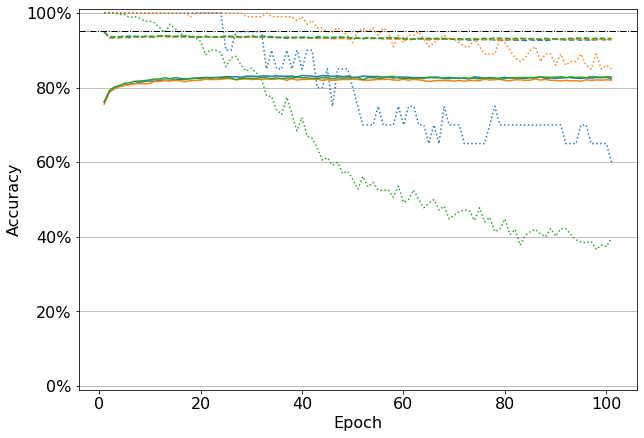

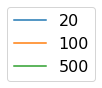

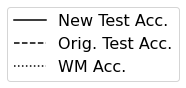

In [31]:
arch='resnet18'
method='ProtectingIP-pattern'

lr = '0.0001'

colors = ["C" + str(i) for i in range(3)]
linestyles = ['-', "--", ":"]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1)
    
for idx, trg_set_size in enumerate([20,100,500]):
    name = 'transfer-learning_' + name_front_all[method][arch] + str(trg_set_size) + '_transfer-learned_' + lr + '_tunealllayers_True'
    
    history = load_obj(name)

    x_arr = np.arange(len(history['test_acc'])) + 1

    ax.plot(x_arr, history['test_acc'], c=colors[idx], ls=linestyles[0], label=r'New Test Acc. (' + str(trg_set_size) + ')')
    ax.plot(x_arr, history['test_acc_orig'], c=colors[idx], ls=linestyles[1], label=r'Orig. Test Acc. (' + str(trg_set_size) + ')')
    ax.plot(x_arr, history['wm_acc'], c=colors[idx], ls=linestyles[2], label=r'WM Acc. (' + str(trg_set_size) + ')')    

ax.axhline(benchmarks_acc[arch], linestyle='-.', color='black', linewidth=1)

# annotate axhline
#ax.text(107,benchmarks_acc[arch], 'Test Acc. w/o WM')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
        
ax.set_ylim((-1,101))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.grid(True)

plt.savefig('thesis/plots/finetuning_protecting_content_trgsetsizes_thesis_' + arch + '.eps', bbox_inches="tight", facecolor='w', edgecolor='w')
#plt.close()
    
lines = ax.get_lines()
        
#dummy lines with NO entries, just to create the black style legend
dummy_lines = []
for j in range(len(linestyles)):
    dummy_lines.append(ax.plot([],[], c="black", ls = linestyles[j])[0])

# legend for linecolors
figsize = (1, 1)
fig_leg1 = plt.figure(figsize=figsize)
ax_leg1 = fig_leg1.add_subplot(111)
legend1 = plt.legend([lines[i] for i in np.arange(3)*3], ['20', '100', '500'], bbox_to_anchor=(0.5, 0.5), loc='center')

ax_leg1.axis('off')
fig_leg1.savefig('thesis/plots/legend_finetuning_protecting_content_trgsetsizes_colors.eps', bbox_inches='tight')

# legend for linestyles
figsize = (1, 1)
fig_leg2 = plt.figure(figsize=figsize)
ax_leg2 = fig_leg2.add_subplot(111)
legend2 = plt.legend(dummy_lines, ['New Test Acc.', 'Orig. Test Acc.', 'WM Acc.'], bbox_to_anchor=(0.5, 0.5), loc='center')

ax_leg2.axis('off')
fig_leg2.savefig('thesis/plots/legend_finetuning_protecting_content_trgsetsizes_linetypes.eps', bbox_inches='tight')